<a href="https://colab.research.google.com/github/gauravlochab/notebooks/blob/main/TabStructNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone -b dependabot/pip/tensorflow-2.3.1 https://github.com/sachinraja13/TabStructNet.git

Cloning into 'TabStructNet'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 709 (delta 24), reused 34 (delta 6), pack-reused 630
Receiving objects: 100% (709/709), 191.59 MiB | 31.53 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Checking out files: 100% (592/592), done.


In [ ]:
!pip install transformers 
import pandas as pd
import numpy as np
import torch
import json
from transformers import BertTokenizerFast, \
  BertForSequenceClassification, Trainer, TrainingArguments
from transformers import PreTrainedModel
from sklearn.model_selection import train_test_split
from transformers import AutoModelForTokenClassification
!pip install wordcloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
# import tensorflow as tf
# from tensorflow.keras.layers import Dense, Input
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ModelCheckpoint
# import tensorflow_hub as hub
# import tokenization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 27.1 MB/s 
     |████████████████████████████████| 101 kB 14.0 MB/s 
     |████████████████████████████████| 6.6 MB 61.3 MB/s 
     |████████████████████████████████| 596 kB 67.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
df = pd.read_csv('./all_data_corrected.csv')
df_service_head = df[['Remarks','ServiceHeads']]
df_service_head

,Remarks,ServiceHeads
0,A SCAN,247
1,ABG,247
2,ACCOMODATION,261
3,ACCOMODATION CHARGES,261
4,ADDITIONAL CHARGES,254
...,...,...
2885,CSSD MATERIALS,254
2886,DISCHARGE SUMMARY,254
2887,USG WHOLE ABD.,247
2888,DR ANURAG VISIT,249


In [ ]:
df['SubCategory'].value_counts()

2017    369
2022    365
2016    336
2009    284
2014    267
2030    263
2015    187
2006    124
2003     88
2010     88
2031     87
2007     83
2039     71
2012     53
2018     50
2002     43
2019     40
2020     21
2033     17
2021     11
2011      9
2024      5
2032      5
2023      5
2034      5
2041      4
2036      4
2035      3
2008      1
2004      1
2005      1
Name: SubCategory, dtype: int64

In [ ]:
counts = df['SubCategory'].value_counts()
res = df[~df['SubCategory'].isin(counts[counts <= 50].index)]
res['SubCategory'].unique()
test_values  =list(range(0, len(res['SubCategory'].unique())))
res_dict = dict(zip(res['SubCategory'].unique(), test_values))
res.replace({"SubCategory": res_dict},inplace=True)
res_final = res[['Remarks','SubCategory']]
res_final.rename(columns = {"SubCategory":"label","Remarks":"text"},inplace=True)
res_final

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,text,label
0,A SCAN,0
1,ABG,0
2,ACCOMODATION,1
3,ACCOMODATION CHARGES,1
4,ADDITIONAL CHARGES,2
...,...,...
2885,CSSD MATERIALS,2
2886,DISCHARGE SUMMARY,2
2887,USG WHOLE ABD.,0
2888,DR ANURAG VISIT,9


In [ ]:
res_dict.keys()

dict_keys([2015, 2030, 2022, 2039, 2007, 2006, 2009, 2014, 2016, 2017, 2010, 2003, 2031, 2012])

In [ ]:
particulars = res_final["text"].to_numpy()
labels = res_final["label"].apply(int).to_numpy()
t_parts, v_parts, t_labels, v_labels = train_test_split(particulars, labels, test_size=0.2, random_state=3199)
texts_train = np.array(t_parts)
label_train = np.array(t_labels)
texts_val = np.array(v_parts)
label_val = np.array(v_labels)
dataset_train = pd.DataFrame({'label': label_train, 'text': list(texts_train)}, columns=['label', 'text'])
dataset_val = pd.DataFrame({'label': label_val, 'text': list(texts_val)}, columns=['label', 'text'])
dataset_train.set_index(dataset_train.columns[0],inplace=True)
dataset_val.set_index(dataset_val.columns[0],inplace=True)

In [ ]:
import re,string
def remove_URL(text):
    text=str(text)
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_mentions(text):
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    return ment.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


dataset_train['clean_text'] = dataset_train['text'].apply(lambda x: remove_URL(x))
dataset_train['clean_text'] = dataset_train['clean_text'].apply(lambda x: remove_emoji(x))
dataset_train['clean_text'] = dataset_train['clean_text'].apply(lambda x: remove_html(x))
dataset_train['clean_text'] = dataset_train['clean_text'].apply(lambda x: remove_mentions(x))
dataset_train['clean_text'] = dataset_train['clean_text'].apply(lambda x: remove_punct(x))
dataset_train['clean_text'] = dataset_train['clean_text'].apply(
    lambda x: x.lower())

cleaned = dataset_train['clean_text'].tolist()

for i,text in enumerate(cleaned):
    splits = text.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    cleaned[i]=' '.join(splits)
    
dataset_train['clean_text']=cleaned

In [ ]:
import re,string
def remove_URL(text):
    text=str(text)
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_mentions(text):
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    return ment.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


dataset_val['clean_text'] = dataset_val['text'].apply(lambda x: remove_URL(x))
dataset_val['clean_text'] = dataset_val['clean_text'].apply(lambda x: remove_emoji(x))
dataset_val['clean_text'] = dataset_val['clean_text'].apply(lambda x: remove_html(x))
dataset_val['clean_text'] = dataset_val['clean_text'].apply(lambda x: remove_mentions(x))
dataset_val['clean_text'] = dataset_val['clean_text'].apply(lambda x: remove_punct(x))
dataset_val['clean_text'] = dataset_val['clean_text'].apply(
    lambda x: x.lower())

cleaned = dataset_val['clean_text'].tolist()

for i,text in enumerate(cleaned):
    splits = text.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    cleaned[i]=' '.join(splits)
    
dataset_val['clean_text']=cleaned

In [ ]:
dataset_train = dataset_train[['clean_text']]
dataset_val = dataset_val[['clean_text']]
dataset_train.dropna(inplace=True)
dataset_val.dropna(inplace=True)

dataset_train =dataset_train[dataset_train['clean_text'].str.len()>3]
dataset_val =dataset_val[dataset_val['clean_text'].str.len()>3]

dataset_train.to_csv('train_super_clean_25_06_22_SAT.csv')
dataset_val.to_csv('val_super_clean_25_06_22_SAT.csv')

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 24.3 MB/s 
     |████████████████████████████████| 140 kB 75.9 MB/s 
     |████████████████████████████████| 212 kB 68.1 MB/s 
     |████████████████████████████████| 1.1 MB 62.5 MB/s 
     |████████████████████████████████| 127 kB 76.9 MB/s 
     |████████████████████████████████| 144 kB 78.3 MB/s 
     |████████████████████████████████| 271 kB 76.6 MB/s 
     |████████████████████████████████| 94 kB 4.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:

from re import split
from datasets import load_dataset

df_train = pd.read_csv('./train_super_clean_25_06_22_SAT.csv')
df_test = pd.read_csv('./val_super_clean_25_06_22_SAT.csv')

local_csv_dataset = load_dataset("csv", data_files={'train': ['/content/train_super_clean_25_06_22_SAT.csv'],'test': '/content/val_super_clean_25_06_22_SAT.csv'})
train_ds = local_csv_dataset["train"]
test_ds = local_csv_dataset["test"]
test_ds[:5]

Using custom data configuration default-8a30ca5fbb1f5c2d


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8a30ca5fbb1f5c2d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

{'clean_text': ['ultrasound wa',
  'anaesthesia charge',
  'accomodation diet',
  'ascan charges',
  'clinical biochemistry'],
 'label': [0, 4, 1, 0, 7]}

In [ ]:
data_pred = test_ds.to_pandas()


In [ ]:
len(y_preds)

525

In [ ]:
data_pred_sub_cat = data_pred.assign(D=y_preds)

In [ ]:
res_dict

{2003: 11,
 2006: 5,
 2007: 4,
 2009: 6,
 2010: 10,
 2012: 13,
 2014: 7,
 2015: 0,
 2016: 8,
 2017: 9,
 2022: 2,
 2030: 1,
 2031: 12,
 2039: 3}

In [ ]:
data_pred_sub_cat.to_csv('pred_label_sub_cat.csv')

In [ ]:
data_pred_sub_cat.loc[data_pred_sub_cat['label'] == 11].head(100)

,label,clean_text,D
9,11,mode int chemocyclecat 2a,2
11,11,pack,11
30,11,mics foldable iol,2
63,11,cataract package charge,11
78,11,arthroscopy procedure others,6
93,11,packages,11
98,11,intra occular lens implanted,6
141,11,complex plasty sstar cathlab dr krish heart care,6
167,11,gipsa package sac 999311,11
230,11,hernioplasty chargesas per package,6


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


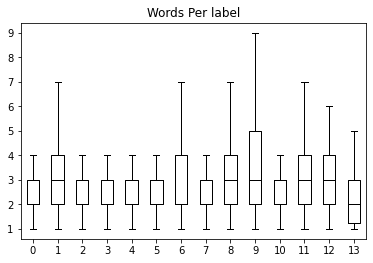

In [ ]:
import matplotlib.pyplot as plt
df_train["Words Per label"] = df_train["clean_text"].str.split().apply(len)
df_train.boxplot("Words Per label", by='label', grid=False, showfliers=False,
color='black', )
plt.suptitle("")
plt.xlabel("");

In [ ]:
from transformers import AutoTokenizer
#model_name = "distilbert-base-uncased"
model_name = "emilyalsentzer/Bio_Discharge_Summary_BERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

from transformers import AutoModelForSequenceClassification
import torch
num_labels = 14
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device))

def tokenize(batch):
  return tokenizer(batch["clean_text"],truncation=True,padding=True,max_length=18)

local_csv_dataset.reset_format()
local_csv_dataset_all = local_csv_dataset.map(tokenize, batched=True, batch_size=None)
local_csv_dataset_all.set_format("torch",columns=["input_ids", "attention_mask", "label"])


from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments

def compute_metrics(pred):
    
      labels = pred.label_ids
      preds = pred.predictions.argmax(-1)
      f1 = f1_score(labels, preds, average="weighted")
      acc = accuracy_score(labels, preds)
      return {"accuracy": acc, "f1": f1}


batch_size = 16
logging_steps = len(local_csv_dataset_all["train"]) // batch_size
training_args = TrainingArguments(output_dir="./health_category_classification_newest_lol_exp",
                                  num_train_epochs=3,
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="steps",
                                  disable_tqdm=False,
                                  logging_steps=100)

from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=local_csv_dataset_all["train"],
                  eval_dataset=local_csv_dataset_all["test"])
trainer.train();

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/emilyalsentzer/Bio_Discharge_Summary_BERT/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/2d918b373f17a0a5546c556b886569530aa77d06fcf1baa2631c28c0feaa69e0.b74d0770929e519c6d193d16b6874051ae549f5c8c228903a48e59d36260466b
Model config BertConfig {
  "_name_or_path": "emilyalsentzer/Bio_Discharge_Summary_BERT",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loadin

Step,Training Loss,Validation Loss,Accuracy,F1
100,1.888500,1.217259,0.674286,0.643655
200,1.016800,0.954129,0.723810,0.720477
300,0.754700,0.833043,0.763810,0.763393


***** Running Evaluation *****
  Num examples = 525
  Batch size = 16
***** Running Evaluation *****
  Num examples = 525
  Batch size = 16
***** Running Evaluation *****
  Num examples = 525
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




In [ ]:
!rm -r /content/health_category_classification_newest_lol_exp

In [ ]:
results = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 525
  Batch size = 16


In [ ]:
preds_output = trainer.predict(local_csv_dataset_all["test"])

***** Running Prediction *****
  Num examples = 525
  Batch size = 16


In [ ]:
local_csv_dataset_all["test"]

Dataset({
    features: ['label', 'clean_text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 525
})

In [ ]:
preds_output.metrics

{'test_accuracy': 0.7657142857142857,
 'test_f1': 0.7636181971062034,
 'test_loss': 0.8153674006462097,
 'test_runtime': 1.1923,
 'test_samples_per_second': 440.319,
 'test_steps_per_second': 27.677}

In [ ]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
preds_output.label_ids

array([ 0,  4,  1,  0,  7,  4,  9, 12,  9, 11,  7, 11,  0,  9,  0,  1,  4,
        9,  2,  8, 13,  7,  5,  7,  1,  1,  9,  1,  8,  5, 11,  4,  8,  1,
        9,  7,  4,  7,  6,  6, 10,  8,  9,  6,  1,  2,  3,  9,  6,  7,  7,
        4,  7,  5, 12,  5,  8,  6,  7, 10,  0,  2,  1, 11,  9,  7,  6,  9,
        6,  2,  1,  1,  9,  4,  6,  1,  1,  3, 11,  1,  7,  1,  6,  6,  7,
        1,  7,  2,  7,  4,  2,  0,  2, 11,  6,  0,  8,  9, 11,  9,  1,  2,
        6,  2,  8,  1, 10, 10,  7,  3,  2,  1,  0,  9,  9,  7,  9,  1, 12,
        9,  0,  3,  2,  8,  8,  9, 10,  8,  1,  2,  6,  7,  7,  0,  6,  6,
        2,  9,  9, 10,  0, 11,  7,  5,  8,  1,  9,  6,  9,  8,  9,  0,  2,
        8,  2,  6,  4,  4,  6,  1,  9,  6,  0,  7,  0,  9,  2, 11,  3,  9,
        0,  9,  2,  1,  6,  3,  6,  2,  7,  9,  9,  1, 10,  1,  8,  9,  0,
        7,  6,  6,  6,  1,  6,  4,  8,  9,  8,  7,  1,  0,  9,  9,  0,  8,
        1, 10,  9,  9,  8,  1,  0, 12,  2,  2,  1,  6,  6,  5,  0,  9,  7,
        8,  1,  2,  1,  2

In [ ]:
import tensorflow as tf

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def visualize_confusion_matrix(y_pred_argmax, y_true):
    """

    :param y_pred_arg: This is an array with values that are 0 or 1
    :param y_true: This is an array with values that are 0 or 1
    :return:
    """

    cm = tf.math.confusion_matrix(y_true, y_pred_argmax).numpy()
    con_mat_df = pd.DataFrame(cm)
    
    print(classification_report(y_pred_argmax, y_true))

    sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

              precision    recall  f1-score   support

           0       0.80      0.85      0.82        41
           1       0.87      0.87      0.87        62
           2       0.63      0.58      0.60        81
           3       0.53      0.60      0.56        15
           4       1.00      0.95      0.97        20
           5       0.56      0.64      0.60        14
           6       0.71      0.67      0.69        58
           7       0.81      0.78      0.80        50
           8       0.78      0.76      0.77        66
           9       0.96      0.90      0.93        79
          10       0.93      0.88      0.90        16
          11       0.59      0.91      0.71        11
          12       0.88      0.88      0.88         8
          13       0.36      1.00      0.53         4

    accuracy                           0.78       525
   macro avg       0.74      0.80      0.76       525
weighted avg       0.79      0.78      0.78       525



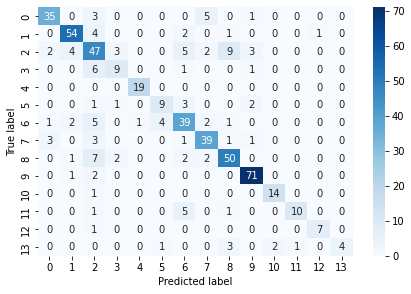

In [ ]:
visualize_confusion_matrix(y_preds, preds_output.label_ids)

In [ ]:
print(classification_report(y_preds, preds_output.label_ids))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80        43
           1       0.89      0.87      0.88        63
           2       0.52      0.57      0.55        68
           3       0.71      0.60      0.65        20
           4       1.00      0.95      0.97        20
           5       0.44      0.54      0.48        13
           6       0.67      0.57      0.62        65
           7       0.75      0.73      0.74        49
           8       0.77      0.86      0.81        57
           9       0.93      0.85      0.89        81
          10       0.93      0.93      0.93        15
          11       0.53      0.60      0.56        15
          12       0.88      0.78      0.82         9
          13       0.64      1.00      0.78         7

    accuracy                           0.75       525
   macro avg       0.75      0.76      0.75       525
weighted avg       0.76      0.75      0.75       525



In [ ]:
import tensorflow as tf

In [ ]:
local_csv_dataset_all["test"]['label']

tensor([ 0,  4,  1,  0,  7,  4,  9, 12,  9, 11,  7, 11,  0,  9,  0,  1,  4,  9,
         2,  8, 13,  7,  5,  7,  1,  1,  9,  1,  8,  5, 11,  4,  8,  1,  9,  7,
         4,  7,  6,  6, 10,  8,  9,  6,  1,  2,  3,  9,  6,  7,  7,  4,  7,  5,
        12,  5,  8,  6,  7, 10,  0,  2,  1, 11,  9,  7,  6,  9,  6,  2,  1,  1,
         9,  4,  6,  1,  1,  3, 11,  1,  7,  1,  6,  6,  7,  1,  7,  2,  7,  4,
         2,  0,  2, 11,  6,  0,  8,  9, 11,  9,  1,  2,  6,  2,  8,  1, 10, 10,
         7,  3,  2,  1,  0,  9,  9,  7,  9,  1, 12,  9,  0,  3,  2,  8,  8,  9,
        10,  8,  1,  2,  6,  7,  7,  0,  6,  6,  2,  9,  9, 10,  0, 11,  7,  5,
         8,  1,  9,  6,  9,  8,  9,  0,  2,  8,  2,  6,  4,  4,  6,  1,  9,  6,
         0,  7,  0,  9,  2, 11,  3,  9,  0,  9,  2,  1,  6,  3,  6,  2,  7,  9,
         9,  1, 10,  1,  8,  9,  0,  7,  6,  6,  6,  1,  6,  4,  8,  9,  8,  7,
         1,  0,  9,  9,  0,  8,  1, 10,  9,  9,  8,  1,  0, 12,  2,  2,  1,  6,
         6,  5,  0,  9,  7,  8,  1,  2, 

In [ ]:
import matplotlib.pyplot as plt
df_train["Words Per label"] = df_train["clean_text"].str.split().apply(len)
df_train.boxplot("Words Per label", by='label', grid=False, showfliers=False,
color='black', )
plt.suptitle("")
plt.xlabel("");

In [ ]:
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import torch
import json
# from transformers import BertTokenizerFast, \
#   BertForSequenceClassification, Trainer, TrainingArguments
# from transformers import PreTrainedModel
# from sklearn.model_selection import train_test_split
# from transformers import AutoModelForTokenClassification
# !pip install wordcloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
# import tensorflow as tf
# from tensorflow.keras.layers import Dense, Input
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ModelCheckpoint
# import tensorflow_hub as hub
# import tokenization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
df = pd.read_csv('./all_data_corrected.csv')
df_service_head = df[['Remarks','ServiceHeads']]
df_service_head

,Remarks,ServiceHeads
0,A SCAN,247
1,ABG,247
2,ACCOMODATION,261
3,ACCOMODATION CHARGES,261
4,ADDITIONAL CHARGES,254
...,...,...
2885,CSSD MATERIALS,254
2886,DISCHARGE SUMMARY,254
2887,USG WHOLE ABD.,247
2888,DR ANURAG VISIT,249


In [ ]:
counts = df['SubCategory'].value_counts()
res = df[~df['SubCategory'].isin(counts[counts < 20].index)]
res['SubCategory'].unique()
test_values  =list(range(0, len(res['SubCategory'].unique())))
res_dict = dict(zip(res['SubCategory'].unique(), test_values))
res.replace({"SubCategory": res_dict},inplace=True)
res_final = res[['Remarks','SubCategory']]
res_final.rename(columns = {"SubCategory":"label","Remarks":"text"},inplace=True)
res_final

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,text,label
0,A SCAN,0
1,ABG,0
2,ACCOMODATION,1
3,ACCOMODATION CHARGES,1
4,ADDITIONAL CHARGES,2
...,...,...
2885,CSSD MATERIALS,2
2886,DISCHARGE SUMMARY,2
2887,USG WHOLE ABD.,0
2888,DR ANURAG VISIT,10


In [ ]:
particulars = res_final["text"].to_numpy()
labels = res_final["label"].apply(int).to_numpy()
t_parts, v_parts, t_labels, v_labels = train_test_split(particulars, labels, test_size=0.2, random_state=3199)
texts_train = np.array(t_parts)
label_train = np.array(t_labels)
texts_val = np.array(v_parts)
label_val = np.array(v_labels)
dataset_train = pd.DataFrame({'label': label_train, 'text': list(texts_train)}, columns=['label', 'text'])
dataset_val = pd.DataFrame({'label': label_val, 'text': list(texts_val)}, columns=['label', 'text'])
dataset_train.set_index(dataset_train.columns[0],inplace=True)
dataset_val.set_index(dataset_val.columns[0],inplace=True)

In [ ]:
import re,string
def remove_URL(text):
    text=str(text)
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_mentions(text):
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    return ment.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


dataset_train['clean_text'] = dataset_train['text'].apply(lambda x: remove_URL(x))
dataset_train['clean_text'] = dataset_train['clean_text'].apply(lambda x: remove_emoji(x))
dataset_train['clean_text'] = dataset_train['clean_text'].apply(lambda x: remove_html(x))
dataset_train['clean_text'] = dataset_train['clean_text'].apply(lambda x: remove_mentions(x))
dataset_train['clean_text'] = dataset_train['clean_text'].apply(lambda x: remove_punct(x))
dataset_train['clean_text'] = dataset_train['clean_text'].apply(
    lambda x: x.lower())

cleaned = dataset_train['clean_text'].tolist()

for i,text in enumerate(cleaned):
    splits = text.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    cleaned[i]=' '.join(splits)
    
dataset_train['clean_text']=cleaned

In [ ]:
import re,string
def remove_URL(text):
    text=str(text)
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_mentions(text):
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    return ment.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


dataset_val['clean_text'] = dataset_val['text'].apply(lambda x: remove_URL(x))
dataset_val['clean_text'] = dataset_val['clean_text'].apply(lambda x: remove_emoji(x))
dataset_val['clean_text'] = dataset_val['clean_text'].apply(lambda x: remove_html(x))
dataset_val['clean_text'] = dataset_val['clean_text'].apply(lambda x: remove_mentions(x))
dataset_val['clean_text'] = dataset_val['clean_text'].apply(lambda x: remove_punct(x))
dataset_val['clean_text'] = dataset_val['clean_text'].apply(
    lambda x: x.lower())

cleaned = dataset_val['clean_text'].tolist()

for i,text in enumerate(cleaned):
    splits = text.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    cleaned[i]=' '.join(splits)
    
dataset_val['clean_text']=cleaned

In [ ]:
df_all = pd.concat([dataset_train,dataset_val])
df_all.reset_index(inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(particulars, labels, test_size=0.2, random_state=3199)

In [ ]:
X_train = X_train.astype('U')
X_test = X_test.astype('U')
y_train = y_train.astype('U')
y_test = y_test.astype('U')

In [ ]:
dataset_train = dataset_train[['clean_text']]
dataset_val = dataset_val[['clean_text']]
dataset_train.dropna(inplace=True)
dataset_val.dropna(inplace=True)

dataset_train =dataset_train[dataset_train['clean_text'].str.len()>3]
dataset_val =dataset_val[dataset_val['clean_text'].str.len()>3]

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_estimators=100)),
                     ])

text_clf.fit(X_train, y_train)


predicted = text_clf.predict(X_test)

print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.81      0.60      0.68        42
           1       0.81      0.79      0.80        63
          10       0.84      0.86      0.85        72
          11       0.32      0.64      0.43        14
          12       0.80      0.50      0.62         8
          13       0.67      0.86      0.75         7
          14       0.64      0.54      0.58        13
          15       0.80      0.75      0.77        16
          16       1.00      0.33      0.50         6
          17       1.00      0.67      0.80         6
           2       0.46      0.55      0.50        56
           3       0.91      0.59      0.71        17
           4       1.00      0.45      0.62        20
           5       0.75      0.60      0.67        25
           6       0.60      0.30      0.40        10
           7       0.75      0.48      0.58        63
           8       0.47      0.85      0.60        65
           9       0.76    

In [ ]:
y_preds, preds_output.label_ids

(array([ 0,  4,  1,  0,  7,  4,  9,  2,  9,  6,  7, 11,  0,  9,  0,  1,  4,
         9,  0,  8,  8,  7,  5,  6,  1,  1,  9,  1, 11,  9,  6,  4,  8,  1,
         9,  7,  4,  7,  6,  4, 10,  8,  9,  6,  1,  1,  3,  9,  2,  1,  2,
         4,  0,  3, 12,  5,  6,  6,  7, 10,  7,  2,  1, 11,  2,  9,  6,  9,
         6,  9,  1, 11,  9,  4,  6,  1,  1,  3,  6,  1,  7,  2,  6,  6,  0,
         1,  8,  2,  7,  4,  6,  7, 12, 11,  6,  0,  2,  9,  6,  9,  1,  8,
         6,  7,  8,  1, 10, 10,  0,  3,  2,  1,  0,  9,  9,  7,  9,  1, 12,
         9,  0,  3,  2,  7,  8,  9, 10,  2,  1,  2,  1,  7,  7,  0,  6, 11,
         1,  9,  9, 10,  0,  6,  7,  5,  8,  1,  2,  9,  9,  8,  9,  0,  2,
         8,  6,  5,  4,  4,  6,  1,  9,  1,  7,  7,  0,  9,  3, 11,  3,  9,
         7,  9,  2,  2,  6,  3,  6,  2,  7,  9,  9,  1, 10,  6,  8,  9,  0,
         7,  6,  6,  6,  1,  6,  4,  8,  9,  8,  0,  1,  0,  9,  9,  0,  8,
         1, 10,  9,  9,  1,  1,  0, 12,  2,  3,  1,  6,  9,  5,  0,  9,  7,
         8, 

In [ ]:
!gdown --id 1PN7IUdDVpz5g66KPPgu_55eK337DiY3b

Downloading...
From: https://drive.google.com/uc?id=1PN7IUdDVpz5g66KPPgu_55eK337DiY3b
To: /content/instances_train2014.json
262MB [00:01, 147MB/s]


In [ ]:
!gdown --id 1_oDTFRtK-OIem6Xrg5-pAjNaChRGncuC

Downloading...
From: https://drive.google.com/uc?id=1_oDTFRtK-OIem6Xrg5-pAjNaChRGncuC
To: /content/instances_val2014.json
168MB [00:01, 157MB/s]


In [ ]:
!gdown --id 1SQi6RElLYYW8FMiBIrLDSnOF40mJkBducd ..

usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--id] url_or_id
gdown: error: unrecognized arguments: ..


In [ ]:
!gdown --id 1NGRMy5FtELc8-fjYSXyxD9c_DalF-7dB

Downloading...
From: https://drive.google.com/uc?id=1NGRMy5FtELc8-fjYSXyxD9c_DalF-7dB
To: /content/mask_rcnn_tab_0120.h5
263MB [00:01, 141MB/s]


In [ ]:
!mv /content/mask_rcnn_coco.h5 /content/TabStructNet/coco_model/coco

In [ ]:
!mv /content/instances_train2014.json /content/TabStructNet/trained_model/tab/annotations

In [ ]:
!mv /content/instances_val2014.json /content/TabStructNet/trained_model/tab/annotations

In [ ]:
!mv /content/mask_rcnn_tab_0100.h5 /content/TabStructNet/trained_model/tab/logs/tab20200821T0923
!mv /content/mask_rcnn_tab_0120.h5 /content/TabStructNet/trained_model/tab/logs/tab20200821T0923

mv: cannot stat '/content/mask_rcnn_tab_0100.h5': No such file or directory


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
cd /content/TabStructNet

/content/TabStructNet


In [ ]:
!pip install -r requirements.txt


     |████████████████████████████████| 320.4MB 50kB/s 
     |████████████████████████████████| 276kB 53.1MB/s 
     |████████████████████████████████| 460kB 45.3MB/s 
     |████████████████████████████████| 163kB 41.2MB/s 
     |████████████████████████████████| 204kB 48.3MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
ERROR: tensorflow 2.3.1 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.5 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py.5b221762ae0507c11741750ec8019445.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copyin

In [ ]:
!pip install tensorflow==1.15.0
!pip install keras==2.2.5

     |████████████████████████████████| 412.3MB 31kB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 512kB 49.8MB/s 
     |████████████████████████████████| 3.8MB 46.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=f181a3baff8a7cb2c76cedb271d7aef1e60c20eccea2367fb656f0d1a97d5421
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [ ]:
!python samples/tabnet/tabnet.py evaluate --dataset=trained_model/tab --model=last --limit=50

Using TensorFlow backend.


2021-02-25 13:14:18.078243: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-02-25 13:14:18.083936: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2021-02-25 13:14:18.084184: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a59cb1f100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-02-25 13:14:18.084315: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-02-25 13:14:18.086709: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-02-25 13:14:18.098124: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-02-25 13:14:18.098173: I tensorflow/stream_executor/c

In [ ]:
!ls trained_model/tab/logs/

tab20200821T0923


In [ ]:
!python samples/tabnet/tabnet.py evaluate --dataset=trained_model/tab --model=last


Using TensorFlow backend.


2021-01-27 07:28:57.116325: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-01-27 07:28:57.121618: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2021-01-27 07:28:57.121857: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2aff2c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-01-27 07:28:57.121892: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-01-27 07:28:57.123976: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-01-27 07:28:57.222225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-

In [ ]:
!rm -r /content/TabStructNet/trained_model/tab/logs/tab20201223T1150

In [ ]:
!python setup.py build

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
!pip install -r requirements.txt

In [ ]:
cd /content/TabStructNet

/content/TabStructNet


In [ ]:
!python setup.py install

In [ ]:
!pip install keras==2.0.8
!pip install tensorflow-gpu==1.15.0
!pip install pycocotools
!pip install scikit-image
!pip install imgaug

In [ ]:
!pip install keras==2.0.8

  Using cached https://files.pythonhosted.org/packages/67/3f/d117d6e48b19fb9589369f4bdbe883aa88943f8bb4a850559ea5c546fefb/Keras-2.0.8-py2.py3-none-any.whl
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [ ]:
!which python

/usr/local/bin/python


In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [ ]:
pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
argon2-cffi==20.1.0
asgiref==3.3.1
astor==0.8.1
astropy==4.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.2.1
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.0
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.4
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.21
daft==0.0.4
dask==2.12.0
dataclasses==0.8
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
Django==3.1.5
dlib==19.18.0
dm-tree==0.1.5
d